### **🟢 Introdução**

**🧠 Smart Allocator V2.0: Regimes de Mercado & Otimização de Portfólio**

<p align="justify">
Este projeto implementa uma estratégia de alocação adaptativa. Utilizamos Gaussian Mixture Models (GMM) para identificar o regime de volatilidade da B3 (Estresse vs. Calmaria) e a Fronteira Eficiente de Markowitz para otimizar os pesos da carteira conforme o cenário atual.

**🧠 Smart Allocator V2.0: Market Regimes & Portfolio Optimization**

<p align="justify">
This project implements an adaptive allocation strategy. We use Gaussian Mixture Models (GMM) to identify B3's volatility regime (Stress vs. Calm) and Markowitz's Efficient Frontier to optimize portfolio weights based on the current market context.

### **🔵 Setup e Blindagem de Dados (Setup & Data Shielding)**

In [1]:
# Instalando biblioteca

#!pip install PyPortfolioOpt

In [2]:
# Carregando bibliotecas

import numpy as np
import pandas as pd
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

from pypfopt import EfficientFrontier, risk_models, expected_returns

In [3]:
# Configurações de exibição e estética
# Display and aesthetic settings

sns.set_theme(style = "whitegrid")

In [4]:
# Parâmetros Iniciais | Initial Parameters

tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA']
indice_ref = "^BVSP"
data_inicio = "2018-01-01"

In [5]:
# Coleta de Dados com tratamento de falhas
# Data Collection with error handling

print("📡 Sincronizando dados da B3 / Syncing B3 data...")
dados = yf.download(tickers + [indice_ref], start=data_inicio)['Close']

📡 Sincronizando dados da B3 / Syncing B3 data...


/tmp/ipython-input-3043471271.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers + [indice_ref], start=data_inicio)['Close']
[*********************100%***********************]  6 of 6 completed


In [6]:
# Limpeza profunda de dados (Tratando NaNs e Inconsistências)
# Deep data cleaning (Handling NaNs and Inconsistencies)

dados_limpos = dados.ffill().dropna()
retornos_mkt = np.log(dados_limpos[[indice_ref]] / dados_limpos[[indice_ref]].shift(1)).dropna()

### **🟡 Célula 2: Motor de Inteligência de Regimes (Regime Detection Engine)**

In [7]:
# Feature Engineering: Retorno e Volatilidade Móvel do Índice
# Feature Engineering: Index Returns and Rolling Volatility

X_regime = pd.concat([
    retornos_mkt,
    retornos_mkt.rolling(22).std() # Janela de 1 mês comercial
], axis=1).dropna()
X_regime.columns = ['Retorno', 'Volatilidade']

In [8]:
# Modelagem GMM para classificar o "clima" do mercado
# GMM Modeling to classify market "weather"

gmm = GaussianMixture(n_components = 2, random_state = 42, n_init = 10)
X_regime['Regime'] = gmm.fit_predict(X_regime)

In [9]:
# Identificando dinamicamente o estado de Estresse
# Dynamically identifying the Stress state

regime_estresse = X_regime.groupby('Regime')['Volatilidade'].mean().idxmax()
X_regime['Status'] = X_regime['Regime'].apply(lambda x: '🚨 ESTRESSE' if x == regime_estresse else '✅ CALMARIA')

print(f"Estado Atual Detectado | Current State Detected: {X_regime['Status'].iloc[-1]}")

Estado Atual Detectado | Current State Detected: ✅ CALMARIA


### **🟠 Célula 3: Otimização de Markowitz (Portfolio Optimization)**

In [10]:
# Preparação dos ativos da carteira (Preços Limpos)
# Portfolio assets preparation (Clean Prices)
df_portfolio = dados_limpos[tickers]

try:
    # Cálculo de Retornos Esperados e Covariância (Ledoit-Wolf Shrinkage)
    # Expected Returns and Covariance Calculation (Ledoit-Wolf Shrinkage)
    mu = expected_returns.mean_historical_return(df_portfolio)
    S = risk_models.CovarianceShrinkage(df_portfolio).ledoit_wolf()

    # Otimização buscando o Melhor Sharpe Ratio
    # Optimization seeking the Best Sharpe Ratio
    ef = EfficientFrontier(mu, S)
    pesos = ef.max_sharpe()
    pesos_limpos = ef.clean_weights()

    # Métricas da Carteira | Portfolio Metrics
    performance = ef.portfolio_performance(verbose=True)

except Exception as e:
    print(f"Erro na Otimização (Defaulting to Min Volatility): {e}")
    ef = EfficientFrontier(mu, S)
    pesos_limpos = ef.min_volatility()

Expected annual return: 24.7%
Annual volatility: 31.2%
Sharpe Ratio: 0.79


### **🟣 Célula 4: Visualização de Alto Impacto (High-Impact Visualization)**

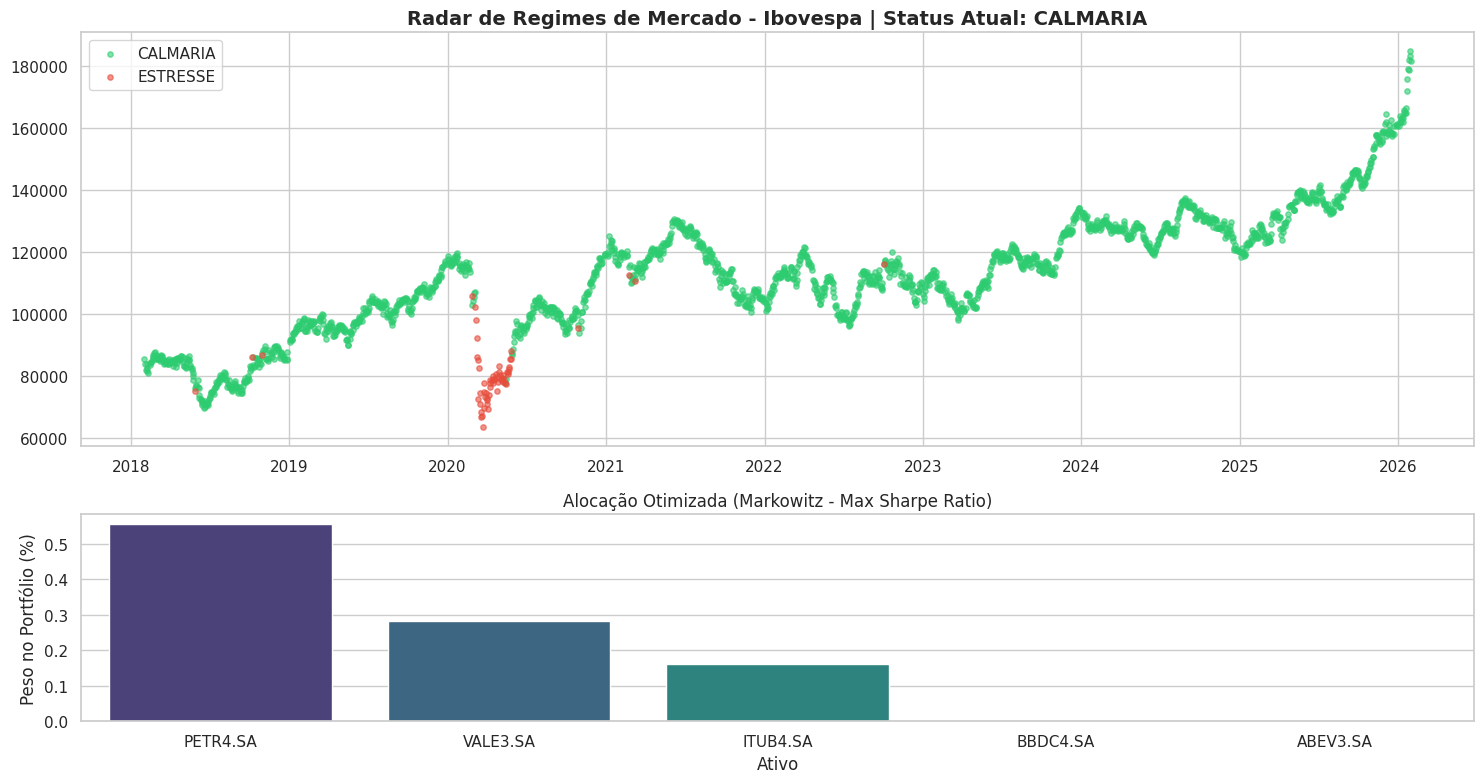

In [11]:
# Ajuste de cores e remoção de emojis para compatibilidade de fontes
# Color adjustment and emoji removal for font compatibility
status_atual = X_regime['Status'].iloc[-1].replace('🚨 ', '').replace('✅ ', '')
cores_map = {'ESTRESSE': '#e74c3c', 'CALMARIA': '#2ecc71'}

fig, ax = plt.subplots(2, 1, figsize = (15, 8), gridspec_kw = {'height_ratios': [2, 1]})

# Gráfico 1: Linha do Tempo de Regimes
for status_raw in X_regime['Status'].unique():
    status_clean = status_raw.replace('🚨 ', '').replace('✅ ', '')
    mask = X_regime['Status'] == status_raw
    ax[0].scatter(X_regime.index[mask], dados_limpos[indice_ref].reindex(X_regime.index)[mask],
                label=status_clean, s = 15, color = cores_map[status_clean], alpha = 0.6)

ax[0].set_title(f"Radar de Regimes de Mercado - Ibovespa | Status Atual: {status_atual}", fontsize = 14, fontweight = 'bold')
ax[0].legend(loc = 'upper left', frameon = True, facecolor = 'white')

# Gráfico 2: Alocação Sugerida (Corrigindo o aviso do Seaborn)
# Plot 2: Suggested Allocation (Fixing Seaborn palette warning)
alocacao_df = pd.Series(pesos_limpos).sort_values(ascending = False).to_frame(name = 'Peso')
alocacao_df['Ativo'] = alocacao_df.index

sns.barplot(
    data=alocacao_df,
    x = 'Ativo',
    y = 'Peso',
    hue = 'Ativo',          # Atribuindo hue para evitar o FutureWarning
    palette = "viridis",
    ax = ax[1],
    legend = False          # Remove legenda redundante já que o eixo X já identifica
)

ax[1].set_title(f"Alocação Otimizada (Markowitz - Max Sharpe Ratio)", fontsize = 12)
ax[1].set_ylabel("Peso no Portfólio (%)")

plt.tight_layout()
plt.show()

In [12]:
# --- RELATÓRIO EXECUTIVO FINAL ---
# --- FINAL EXECUTIVE REPORT ---

print("\n" + "="*55)
print(f"📊 RELATÓRIO DE ALOCAÇÃO ADAPTATIVA | ADAPTIVE REPORT")
print("="*55)
print(f"CONTEXTO ATUAL | CURRENT CONTEXT: {X_regime['Status'].iloc[-1]}")
print("-" * 55)

# Iterando sobre as linhas do DataFrame de alocação
# Iterating through the allocation DataFrame rows
for index, row in alocacao_df.iterrows():
    ativo = row['Ativo']
    peso = row['Peso']
    if peso > 0.0001:  # Filtra pesos irrelevantes ou zero
        print(f"🔹 {ativo:.<15} {peso:>10.2%}")

print("="*55)

# Métricas Adicionais de Performance (O toque Sênior)
# Additional Performance Metrics (The Senior touch)
retorno_esp, vol_esp, sharpe = performance
print(f"📈 Retorno Esperado Anual | Expected Return: {retorno_esp:.2%}")
print(f"📉 Volatilidade Anual   | Annual Volatility: {vol_esp:.2%}")
print(f"🏆 Índice Sharpe        | Sharpe Ratio:      {sharpe:.2f}")
print("="*55)


📊 RELATÓRIO DE ALOCAÇÃO ADAPTATIVA | ADAPTIVE REPORT
CONTEXTO ATUAL | CURRENT CONTEXT: ✅ CALMARIA
-------------------------------------------------------
🔹 PETR4.SA.......     55.45%
🔹 VALE3.SA.......     28.32%
🔹 ITUB4.SA.......     16.23%
📈 Retorno Esperado Anual | Expected Return: 24.75%
📉 Volatilidade Anual   | Annual Volatility: 31.23%
🏆 Índice Sharpe        | Sharpe Ratio:      0.79
